In [85]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

img1 = cv2.imread('../src/ransac1.jpg', cv2.IMREAD_GRAYSCALE)          # queryImage
img2 = cv2.imread('../src/ransac2.jpg', cv2.IMREAD_GRAYSCALE)   # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create(nfeatures=30)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 1*n.distance:
        good.append(m)

In [86]:
class findHomography:
    def __init__(self, src, dst, threshold) -> None:
        src = src.reshape(-1, 2)
        dst = dst.reshape(-1, 2)
        self.src = np.hstack((src, np.ones((src.shape[0], 1))))
        self.dst = np.hstack((dst, np.ones((dst.shape[0], 1))))
        self.threshold = threshold
        self.mask = None
        self.M = None
        self.n_points = 4

    def ransac(self):
        best_error = np.inf
        for _ in range(1000):
            src, dst = self.selection()
            H = self.homographyMat(src, dst)
            error, overallError = self.reprojectionError(H)
            if overallError < best_error:
                best_error = overallError
                self.H = H
                self.mask = np.where(error<self.threshold, 1, 0)
        return self.H, self.mask.reshape(-1, 1).astype(np.int8)

    def selection(self):
        indices = np.random.choice(self.src.shape[0], self.n_points, replace=False)
        return self.src[indices], self.dst[indices]

    def normalize(self, arr1, arr2):
        min1, max1 = np.min(arr1), np.max(arr1)
        min2, max2 = np.min(arr2), np.max(arr2)
        arr1 = (arr1 - min1) / (max1 - min1)
        arr2 = (arr2 - min2) / (max2 - min2)
        return arr1, arr2

    def homographyMat(self, src, dst):
        src, dst = self.normalize(src, dst)
        x  = src
        xp = dst
        A = []
        for i in range(self.n_points):
            xi = x[i]
            xip = xp[i]
            A.append([xi[0], xi[1], 1, 0,     0,     0, -xip[0]*xi[0], -xip[0]*xi[1], -xip[0]])
            A.append([0,     0,     0, xi[0], xi[1], 1, -xip[1]*xi[0], -xip[1]*xi[1], -xip[1]])
        A = np.array(A)
        U, S, Vt = np.linalg.svd(A)
        H = Vt[-1].reshape((3, 3))
        H /= H[2, 2]  # Normalize to ensure H[2, 2] is 1
        return H.astype(np.float64)

    def reprojectionError(self, H):
        error = []
        H_inv = np.linalg.pinv(H)
        for i in range(len(self.src)):
            x1 = self.dst[i]
            x2 = H @ self.src[i]
            temp_err = np.sum((x1 - x2)**2)

            x1 = self.src[i]
            x2 = H_inv @ self.dst[i]
            temp_err += np.sum((x1 - x2)**2)

            error.append(temp_err)
        error = np.array(error, dtype=np.float128)
        overall = np.sum(error)
        error = (error - np.min(error)) / (np.max(error) - np.min(error))
        return error, overall

In [87]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.int16([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.int16([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = findHomography(src_pts, dst_pts, .01).ransac()

    # M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

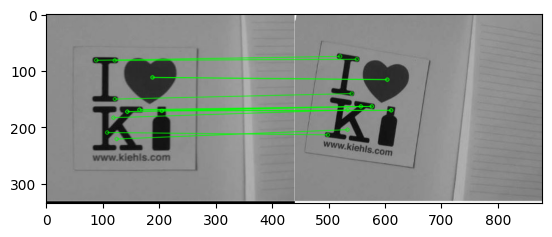

(<matplotlib.image.AxesImage at 0x7bb7a5beece0>, None)

In [88]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()